## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera calibration using chessboard images

In this section we take checkerboard images taken from the camera used to film video for this assignment and use it for calibration. I use cv2.findChessboardCorners to generate objpoints and imgpoints. imgpoints are just 2d coordinates of a flat image. objpoints are represent how these float 2d coordinates are mapped in a 3d space. Both of the these will help us with calibration and ultimately undistort the images that the camera produces. Below I display a set of before and after images with the test set provided.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Use calibrations to undistort images

With objpoints and imgpoints generated in the last step, we pass it into v2.calibrateCamera to essentially give us the camera calibration and distortion coefficients. This enables us to call cv2.undistort to undistort the images the camera generates.

Distorted Set


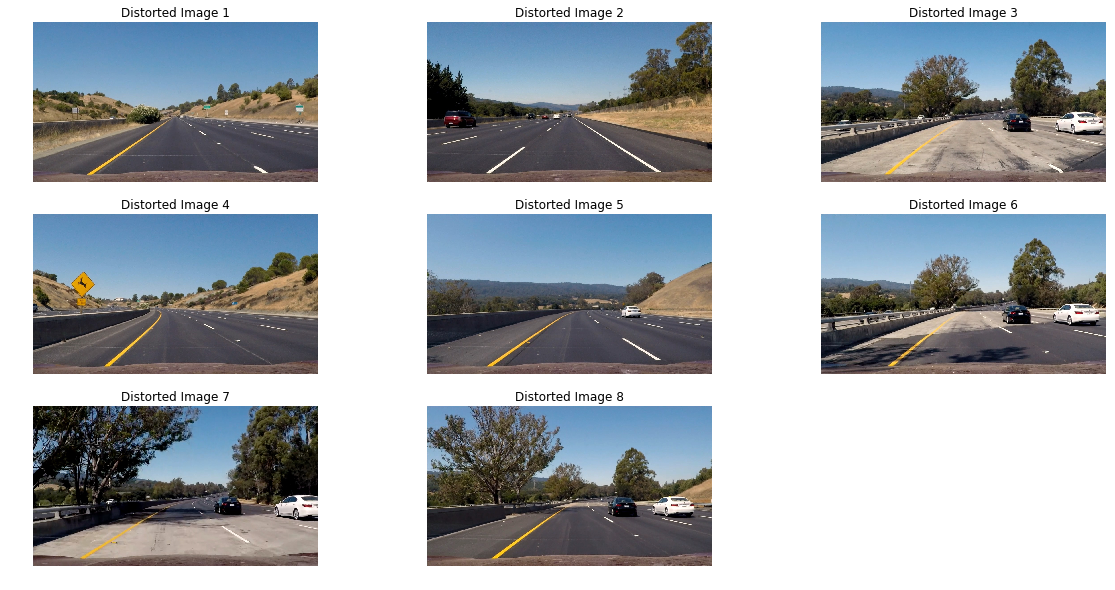

Undistorted Set


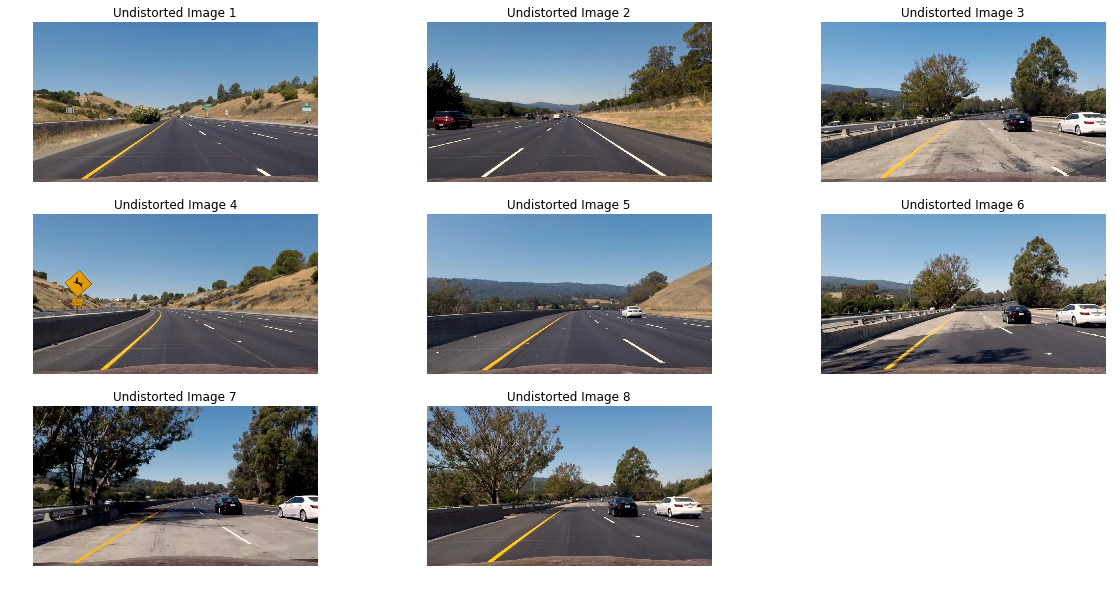

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
# Visualizations will be shown in the notebook.
%matplotlib inline

# Performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    return img

# Visualize effect of calibration and distortion correction
test_images = glob.glob('./test_images/*.jpg')
print("Distorted Set")
plt.figure(figsize=(20,10))
i = 1
for filename in test_images:
    plt.subplot(3, 3, i)
    plt.axis('off')
    plt.title("Distorted Image %s" % i)
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image.squeeze())
    i += 1
plt.show()

print("Undistorted Set")
plt.figure(figsize=(20,10))
i = 1
for filename in test_images:
    plt.subplot(3, 3, i)
    plt.axis('off')
    plt.title("Undistorted Image %s" % i)
    image = cv2.imread(filename)
    image = cal_undistort(image, objpoints, imgpoints)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image.squeeze())
    i += 1
plt.show()

## Perspective Transform

Now that we have images that are free of distortion from the camera lens its time to think about how to accurately measure curvature of the lane lines. When using the images as-is its quite hard to see or measure the curviture of the lane lines - they all generally look like their going straight and pointing inwards. Luckily we can utilize perspective tranform to view the lane lines from a birds-eye view.

To do that I create 2 sets of coordinates to feed into my method perspective_transform that utilizes cv2.warpPerspective - src and dst. src is a set of coordinates (4) that forms a trapezoid that map to the lane lines. dst is a set of coordinates (4) of where we want to warp the lane line coordinates to to achieve a birds-eye view. 

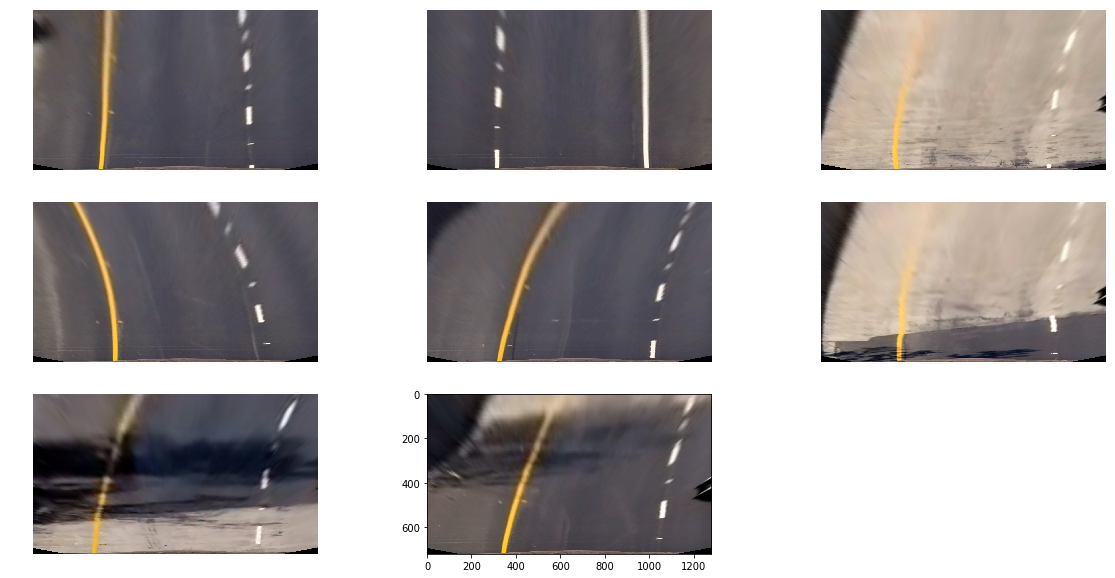

In [4]:
def perspective_trasform(image, src, dst):
    # Grab the image shape
    img_size = (image.shape[1], image.shape[0])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Inverse
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

    # Return the resulting image and matrix
    return warped, M, Minv

# Lets test this out and see what the perspective transform looks like. Goal it to achive parallel lines! 
plt.figure(figsize=(20,10))
i = 1
offset = 300
for filename in test_images:
    image = cv2.imread(filename)
    
    # Calling our calibration function first
    image = cal_undistort(image, objpoints, imgpoints)
    img_size = (image.shape[1], image.shape[0])
    # Arbitrarily picked coordinates from image to form mask
    src = np.float32([[590, 450], [690, 450], [1100, 720], [200, 720]])
    dst = np.float32([[offset, 0], [img_size[0]-offset, 0], 
                     [img_size[0]-offset, img_size[1]],[offset, img_size[1]]]) 
    
    image, M, Minv = perspective_trasform(image, src, dst)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.subplot(3, 3, i)
    plt.imshow(image.squeeze())
    i += 1
plt.show()

## Edge Detection
Before we jump into actual lane line detections we have to obscure or remove unnessary information/objects from the images as much as we can. Without doing this we cannot accurately detect where the lines are since shadows or even color variation can throw off our lane detection algorithm. In this section I utilize a few thresholding methods for edge detection.

There are several methods we can utilize:
- Sobel Thresholding
- Thresholding of Magnitude of Gradient
- Threholding of Gradient Direction
- Color Thresholding

This required a ton of tinkering with the thresholds, but ultimately I decided not to use some of them as I didn't see any benefits at the time. What I ended up utilizing was Sobel in the x and y direction as well as color thresholding (HSV and HSL) to achieve "optimum" results. But as you can tell from the resulting images there is still A LOT to be removed from these images - its still quite noisy. This really effected how well the lane detection performed. Many times in the resulting video you'll see the a lot of "wiggling" and at time you'll see the lane lines curve in ways they aren't supposed to. I definitely struggled here to find the "optimal" combination and thresholding to remove image noise.

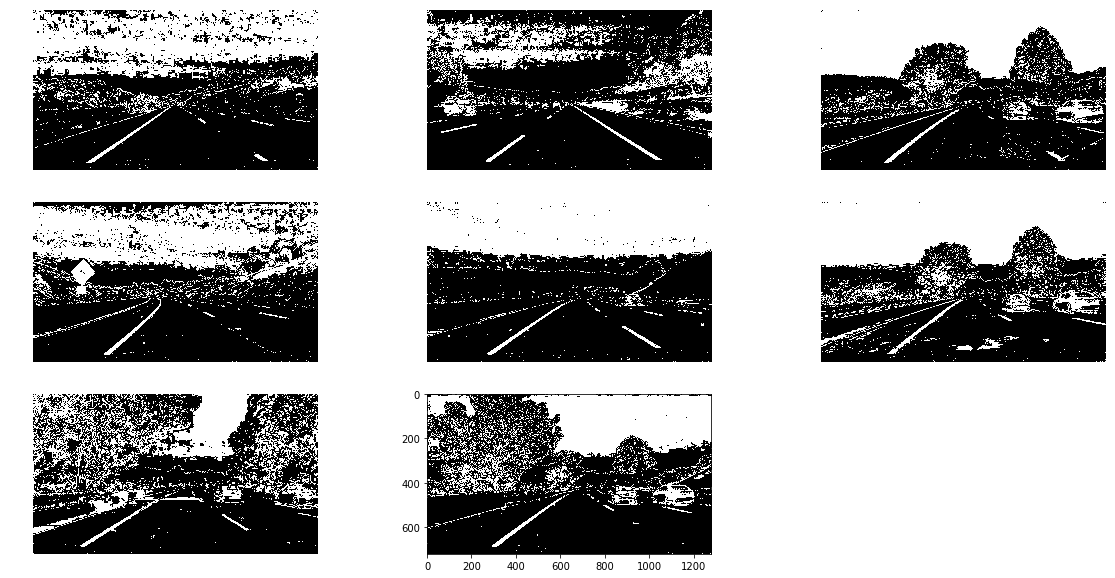

In [25]:
# Define a function that applies Sobel x or y,
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)

    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))

    # 5) Create a mask of 1's where the scaled gradient magnitude
    # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image

    return sbinary


# Define a function that applies Sobel x and y,
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Calculate the magnitude
    magnitude = np.sqrt(sobelx ** 2 + sobely ** 2)

    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_mag = np.uint8(255 * magnitude / np.max(magnitude))

    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(scaled_mag)
    binary_output[(scaled_mag >= mag_thresh[0]) & (scaled_mag <= mag_thresh[1])] = 1

    return binary_output


# Define a function that applies Sobel x and y,
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi / 2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)

    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    graddir = np.arctan2(abs_sobely, abs_sobelx)

    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(graddir)
    binary_output[(graddir >= thresh[0]) & (graddir <= thresh[1])] = 1

    return binary_output

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def color_select(img, sthresh=(0, 255), vthresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_output = np.zeros_like(s_channel)
    s_output[(s_channel > sthresh[0]) & (s_channel <= sthresh[1])] = 1
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_output = np.zeros_like(s_channel)
    v_output[(s_channel > vthresh[0]) & (s_channel <= vthresh[1])] = 1
    
    binary_output = np.zeros_like(v_output)
    binary_output[(v_output == 1) & (s_output == 1)] = 1
    
    return binary_output

def threshold(image, ksize=3):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(12, 255))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(25, 255))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(90, 255))
    c_binary = color_select(image, sthresh=(100,255), vthresh=(50,255))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, np.pi/2))
    
    
    combined = np.zeros_like(image[:,:,0])
    combined[((gradx == 1) & (grady == 1)| (c_binary == 1))] = 255

    return combined

# Lets test this out and see what it looks like in a few test images
plt.figure(figsize=(20,10))
i = 1
for filename in test_images:
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    image = threshold(image, 5)
    plt.axis('off')
    plt.subplot(3, 3, i)
    plt.imshow(image, cmap='gray')
    i += 1
plt.show()


## Combining Techniques

Here we visualize everything I've covered so far. Generally speaking they looked "good enough", but I think there is still a lot of room for improvement.

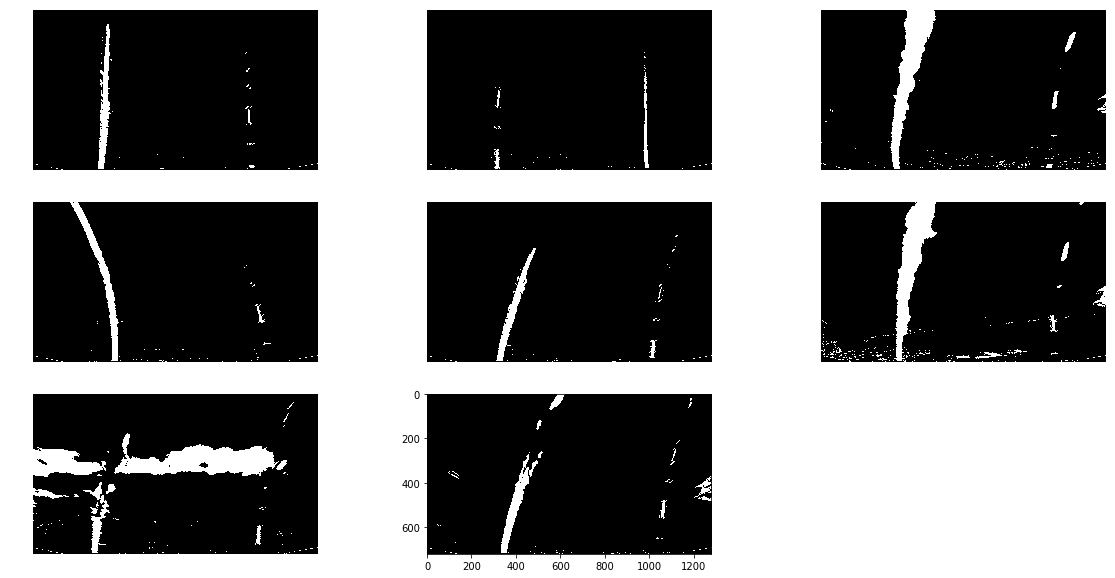

In [24]:
# Lets test this out and see what it looks like in a few test images
plt.figure(figsize=(20,10))
i = 1
offset = 300
for filename in test_images:
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Calling our calibration function first
    image = cal_undistort(image, objpoints, imgpoints)

    img_size = (image.shape[1], image.shape[0])
    # Arbitrarily picked coordinates from image to form mask
    src = np.float32([[590, 450], [690, 450], [1100, 720], [200, 720]])
    dst = np.float32([[offset, 0], [img_size[0]-offset, 0], 
                     [img_size[0]-offset, img_size[1]],[offset, img_size[1]]]) 
    
    image, M, Minv = perspective_trasform(image, src, dst)
    image = threshold(image, 3)
    plt.axis('off')
    plt.subplot(3, 3, i)
    plt.imshow(image, cmap='gray')
    i += 1
plt.show()

## Finding the Lanes

This was probably the most challenging section for me. I decided to the use the convolving technique outlined in the class lectures as it seemed to be the most straight forward. I created a tracker class, covered in the office hours, to utilize information we gathered from previous images so we can have smoother transitions between images and less wiggling/jittering in our lane lines. 

In [26]:
class tracker():
    def __init__(self,window_width,window_height,margin,ym = 1,xm = 1,smooth_factor = 15):
        self.recent_centers=[]
        self.window_width = window_width
        self.window_height = window_height
        self.margin = margin
        self.ym_per_pix = ym
        self.xm_per_pix = xm
        self.smooth_factor = smooth_factor
        
    def find_window_centroids(self,warped):
        window_width = self.window_width
        window_height = self.window_height
        margin = self.margin
        
        # centroid left and right pairs
        window_centroids = []
        
        window = np.ones(window_width)
       
        l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
        l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
        r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
        r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
        window_centroids.append((l_center,r_center))
        last_l_center = l_center
        
        for level in range(1,(int)(warped.shape[0]/window_height)):
            image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):
                                        int(warped.shape[0]-level*window_height),:], axis=0)
            
            conv_signal = np.convolve(window,image_layer)
            offset = window_width/2
           
            l_min_idx = int(max(l_center+offset-margin,0))
            l_max_idx = int(max(l_center+offset+margin,warped.shape[1]))
            l_center = np.argmax(conv_signal[l_min_idx:l_max_idx]) + l_min_idx - offset
            
          
            r_min_idx = int(max(r_center+offset-margin,0))
            r_max_idx = int(max(r_center+offset+margin,warped.shape[1]))
            r_center = np.argmax(conv_signal[r_min_idx:r_max_idx]) + r_min_idx - offset
           
            if abs(last_l_center-l_center)>200:
                l_center = last_l_center
            else:
                last_l_center = l_center
            window_centroids.append((l_center,r_center))
        
        self.recent_centers.append(window_centroids)
        return np.average(self.recent_centers[-self.smooth_factor:],axis=0)

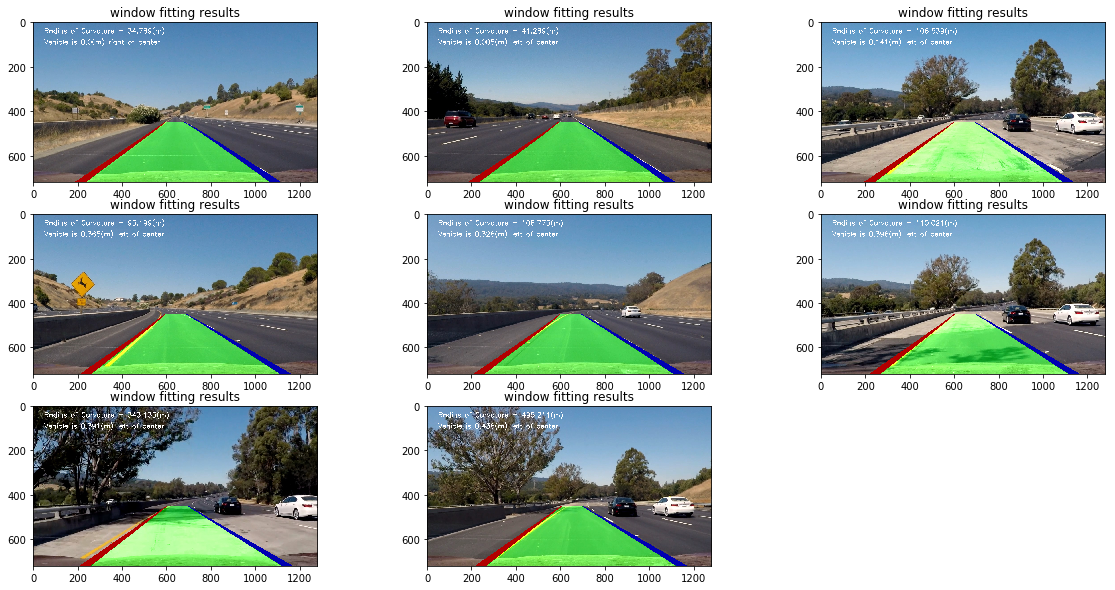

In [27]:
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching
curve_centers = tracker(window_width = window_width, window_height = window_height, margin = 25, ym = 10/720, xm = 4/384, smooth_factor = 15)
    
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def process_image(image):
    # Calling our calibration function first
    undistorted = cal_undistort(image, objpoints, imgpoints)
    img_size = (undistorted.shape[1], undistorted.shape[0])
    
    # Arbitrarily picked coordinates from image to form mask
    src = np.float32([[590, 450], [690, 450], [1100, 720], [200, 720]])
    dst = np.float32([[offset, 0], [img_size[0]-offset, 0], 
                     [img_size[0]-offset, img_size[1]],[offset, img_size[1]]]) 
    
    transformed, M, Minv = perspective_trasform(undistorted, src, dst)
    warped = threshold(transformed, 5)
    
    window_centroids = curve_centers.find_window_centroids(warped)
    
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
    
    rightx = []
    leftx = []

    # Go through each level and draw the windows 
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add center value found in frame to the list of lane points per left, right
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # fit the lane boundaries to the left,right center positions found
    yvals = range(0,warped.shape[0])
    
    res_yvals = np.arange(warped.shape[0]-(window_height/2),0,-window_height)
    
    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
    left_fitx = np.array(left_fitx, np.int32)
    
    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    right_fitx = np.array(right_fitx, np.int32)
    
    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2,left_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2,right_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    middle_marker = np.array(list(zip(np.concatenate((left_fitx+window_width/2,right_fitx[::-1]-window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    
    
    road = np.zeros_like(undistorted)
    road_bkg = np.zeros_like(undistorted)
    cv2.fillPoly(road,[left_lane],color=[255,0,0])
    cv2.fillPoly(road,[right_lane],color=[0,0,255])
    cv2.fillPoly(road,[middle_marker],color=[0,200,0])
    cv2.fillPoly(road_bkg,[left_lane],color=[255,255,255])
    cv2.fillPoly(road_bkg,[right_lane],color=[255,255,255])

    road_warped = cv2.warpPerspective(road, Minv, img_size,flags=cv2.INTER_NEAREST)
    road_warped_bkg = cv2.warpPerspective(road_bkg, Minv, img_size,flags=cv2.INTER_NEAREST)

    road_base = cv2.addWeighted(image, 1, road_warped_bkg, -1.0, 0.0)
    road_combined = cv2.addWeighted(road_base, 1, road_warped, 0.7, 0.0)
    
    xm_per_pix = curve_centers.xm_per_pix
    ym_per_pix = curve_centers.ym_per_pix
    curve_fit_cur =  np.polyfit(np.array(res_yvals,np.float32)*ym_per_pix, np.array(rightx,np.float32)*xm_per_pix, 2)
    curverad = ((1 + (2*curve_fit_cur[0]*yvals[-1]*ym_per_pix + curve_fit_cur[1])**2)**1.5) / np.absolute(2*curve_fit_cur[0])
    
    camera_center = (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (camera_center-warped.shape[1]/2)*xm_per_pix
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'
        
    #display the info 
    cv2.putText(road_combined,'Radius of Curvature = '+str(round(curverad,3))+'(m)',(50,50), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    cv2.putText(road_combined,'Vehicle is '+str(abs(round(center_diff,3)))+'(m) '+side_pos+' of center',(50,100), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    
    return road_combined

plt.figure(figsize=(20,10))
i = 1
offset=200
for filename in test_images:
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = process_image(image)
    plt.subplot(3, 3, i)

    i += 1
    plt.imshow(result)
    plt.title('window fitting results')
plt.show()


## Apply it to the video!

In [28]:
from moviepy.editor import *
clip = VideoFileClip('project_video.mp4')
output = clip.fl_image(process_image)
output.write_videofile('output_track1.mp4')

[MoviePy] >>>> Building video output_track1.mp4
[MoviePy] Writing audio in output_track1TEMP_MPY_wvf_snd.mp3


100%|██████████| 1112/1112 [00:00<00:00, 2866.61it/s]

[MoviePy] Done.
[MoviePy] Writing video output_track1.mp4



100%|█████████▉| 1260/1261 [14:53<00:00,  1.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_track1.mp4 



## Conclusion
The resulting video was ultimately not that great. I think that time needs to be spent on the "Edge Detection" section to find a better combination that will remove more noise from our images. The better the noise removal the better our lane line detection will be. 